# Clustering answers

We cluster the most frequently annotated answers by category and plot them in a 2D graph.

In [111]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5, "lines.markersize": 8})

%matplotlib inline

In [112]:
import json

from lqam.methods.dataset import URL_DATA_TEST, URL_DATA_VAL
from lqam.util.file_utils import cached_path

with open(cached_path(URL_DATA_VAL)) as file:
    val_data = json.load(file)

with open(cached_path(URL_DATA_TEST)) as file:
    test_data = json.load(file)

instances = val_data + test_data

In [113]:
from lqam.core.metrics import normalize_answer

# If one answer occurs multiple times for one blanked caption, we count it only once.
answer_counts = pd.Series(answer
                          for instance in instances
                          for answer in {normalize_answer(answer)
                                         for worker_answers in instance["additional_answers"]
                                         for answer in worker_answers}).value_counts()

answer_counts.head(20)

person       409
man          310
guy          230
someone      226
woman        173
girl         156
people       152
boy          142
kid          132
male         129
lady         128
child        126
room          89
group         87
female        83
kids          79
it            76
human         73
gentleman     71
adult         62
dtype: int64

In [114]:
top_k = 300
answers = list(set(answer_counts.head(top_k).keys().tolist()))

In [115]:
from sentence_transformers import SentenceTransformer

embeddings = SentenceTransformer("stsb-roberta-base").encode(answers)
embeddings /= np.linalg.norm(embeddings, axis=1, keepdims=True)
embeddings.shape

In [117]:
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(n_clusters=6, affinity="cosine", linkage="average")
clustering_model.fit(embeddings)

clusters = defaultdict(list)
for id_, answer in zip(clustering_model.labels_, answers):
    clusters[id_].append(answer)

clusters

defaultdict(<class 'list'>, {0: ['side', 'glass', 'melody', 'music', 'glasses', 'surface', 'animal', 'musical instrument', 'son', 'fire', 'material', 'professional', 'employee', 'stage', 'equipment', 'multitude', 'structure', 'viewers', 'teacher', 'mountain', 'object', 'performers', 'tricks', 'dirt', 'place', 'front of camera', 'tree', 'weights', 'floor', 'rod', 'ground', 'spectators', 'worker', 'class', 'top', 'knife', 'view', 'blade', 'set', 'seat', 'steel', 'exercises', 'earth', 'items', 'song', 'trainer', 'front', 'performer', 'sounds', 'dancers', 'desk', 'tool', 'chair', 'machine', 'wall', 'lake', 'pool', 'toy', 'sidewalk', 'building', 'car', 'tutorial', 'dude', 'instructor', 'device', 'pond', 'metal', 'soil', 'sand', 'circle', 'studio', 'ice', 'rock', 'exercise', 'edge', 'dancer', 'narrator', 'park', 'camera', 'path', 'workers', 'artist', 'animals', 'instructions', 'water', 'dish', 'part', 'vehicle', 'her feet', 'dance', 'rope', 'toddler', 'picture', 'design', 'hill', 'tools', 'f

In [118]:
clusters = {
    "Person-related": {"another person", "artist", "audience", "baby", "band", "chef", "children", "competitors", "crowd", "dancer", "daughter", "employee", "father", "female", "friend", "group of people", "herself", "host", "humans", "infant", "lady", "mother", "musician", "old man", "other people", "person", "siblings", "son", "spectators", "student", "teenager", "trainer", "viewers", "workers", "young man", "youth"},
    "Body parts": {"fingers", "hair", "head", "her feet", "her head", "his body", "his hands", "legs"},
    "Position": {"back", "front", "left", "right"},
    "Materials": {"carpet", "cloth", "dirt", "fire", "grass", "ice", "liquid", "metal", "paper", "pond", "rock", "sand", "snow", "steel", "wall", "wood"},
    "Objects": {"baseball", "bed", "board", "bowl", "brush", "car", "desk", "dish", "dish", "equipment", "food", "glasses", "hill", "liquid", "musical instrument", "pan", "pole", "shoes", "stick", "table", "toy", "tree", "tube", "tube"},
    "Places": {"background", "backyard", "class", "courtyard", "field", "floor", "his house", "home", "kitchen", "living room", "mountain", "park", "pavement", "room", "stage", "street", "studio"},
}

In [124]:
color_by_cluster = {k: color for k, color in zip(clusters, sns.color_palette("hls", n_colors=len(clusters)))}

In [120]:
from sklearn.manifold import TSNE

embeddings_2d = TSNE(n_components=2, init="random", learning_rate="auto").fit_transform(embeddings)

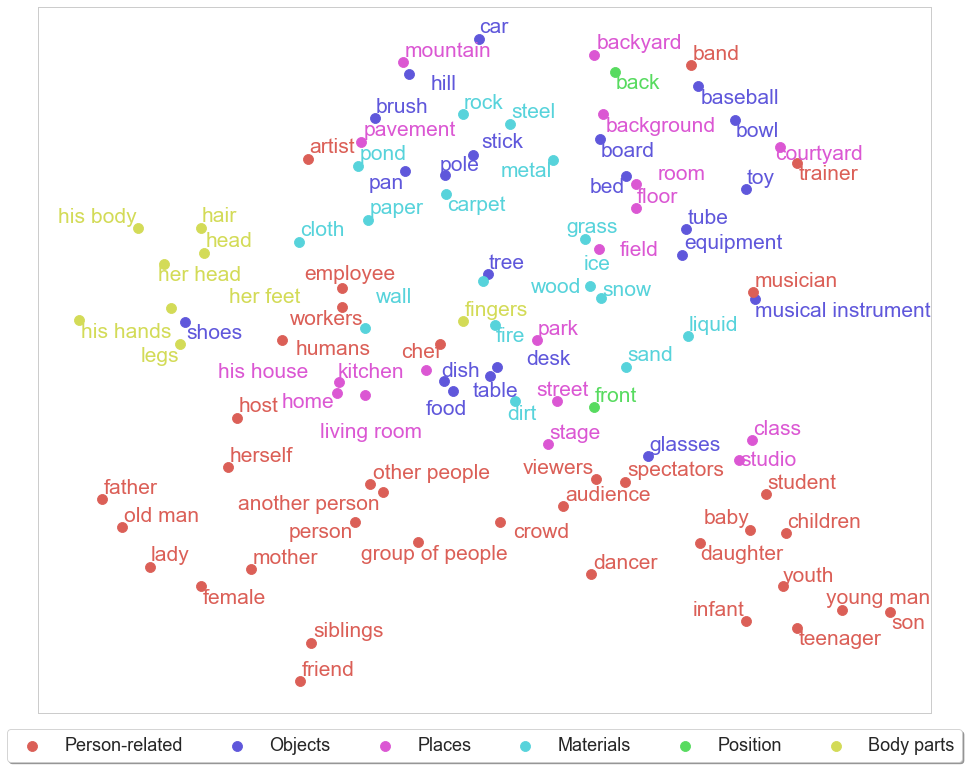

In [125]:
from adjustText import adjust_text

plt.figure(figsize=(16, 13))

points_by_cluster = defaultdict(list)

for answer, (x, y) in zip(answers, embeddings_2d):
    cluster_id = next((k for k, cluster_answers in clusters.items() if answer in cluster_answers), None)
    if cluster_id:
      plt.scatter(x, y, color=color_by_cluster[cluster_id], s=100,
                  label=None if cluster_id in points_by_cluster else cluster_id)
      points_by_cluster[cluster_id].append((x, y, answer))

adjust_text([plt.text(x, y, answer, ha="right", va="bottom", size=21, color=color_by_cluster[k], wrap=True)
             for k, points in points_by_cluster.items()
             for x, y, answer in points])

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.01), ncol=len(clusters), shadow=True, prop={"size": 18})
plt.yticks([])
plt.xticks([])

plt.gcf().savefig("clusters.pdf", bbox_inches="tight")